# imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# data

In [2]:
train_x_ori = pd.read_csv("../data/dengue_features_train.csv")
train_y_ori = pd.read_csv("../data/dengue_labels_train.csv")

# Data exploration

In [3]:
train_x_ori

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0


In [4]:
train_y_ori

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6
...,...,...,...,...
1451,iq,2010,21,5
1452,iq,2010,22,8
1453,iq,2010,23,1
1454,iq,2010,24,1


In [5]:
#check duplicates
print(f' trainX duplicates? {train_x_ori.duplicated().unique()}')
print(f' trainY duplicates? {train_y_ori.duplicated().unique()}')

 trainX duplicates? [False]
 trainY duplicates? [False]


In [6]:
# a little bit of preprocessing
class ByCityPreprocessing:
    def __init__(self, df, target, city="sj"):
        
        self.city = city
        df = df.groupby("city").get_group(city).copy()
        df = self.drop_columns(df, ["week_start_date", "city"])
        # df = df.fillna(method="ffill")
        self.df = df
        
        target = target.loc[df.index]
        target = self.drop_columns(target, ["weekofyear", "year", "city"])
        self.target = target
        
    def get_df_and_target(self):
        return (self.df, self.target)      
    
    def drop_columns(self, df, columns: list):
        for column in columns:
            df.drop(column, axis=1, inplace=True)
        return df
            
# train only for sj city
X, y = ByCityPreprocessing(
    train_x_ori, 
    train_y_ori, 
    city="sj"
).get_df_and_target()

In [7]:
X.head()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


<Axes: >

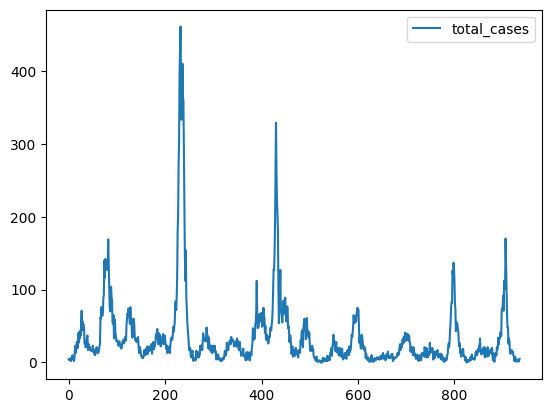

In [8]:
# plot the target
y.plot()

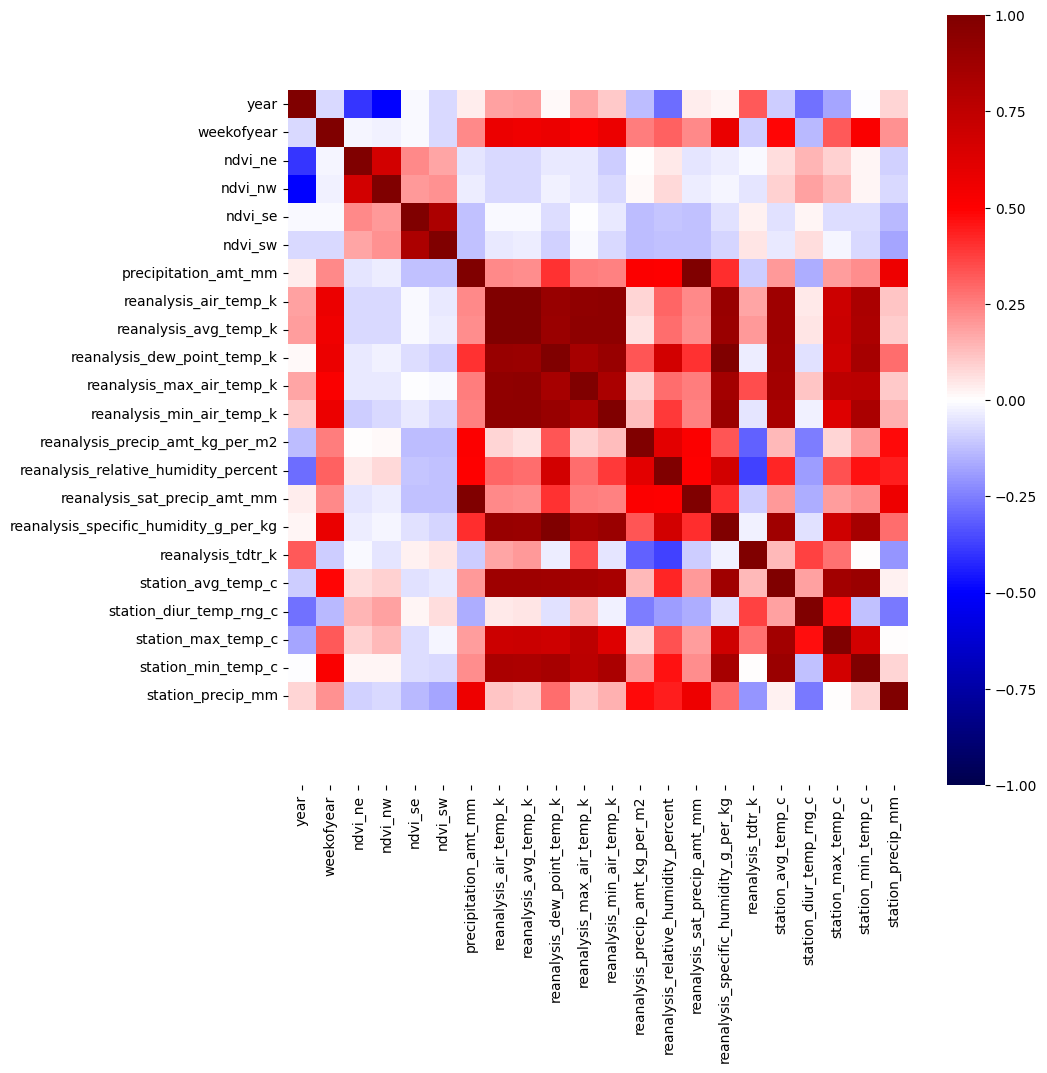

In [9]:
#get correlations of each features in dataset
def plot_corr(data):
    corrmat = data.corr()   #get correlations table
    top_corr_features = corrmat.index
    plt.figure(figsize=(10,10))
    #plot heat map
    max_plotted_r = 1
    g=sns.heatmap(
        data[top_corr_features].corr(),
        annot=False,
        cmap="seismic", 
        vmin=-max_plotted_r, vmax=max_plotted_r
    )
    plt.axis("equal")
    
plot_corr(X)

In [ ]:
def select_k_best(X, y, k=10, score_func=chi2):
    # nans need to be removed first
    data_selector = SelectKBest(score_func=f_classif, k=k)
    best_features = data_selector.fit_transform(X, y)
    selection_results = pd.DataFrame(
        {
            "specs": X.columns, 
            "score": data_selector.fit(X, y).scores_
        }
    )
    print("best parameters sorted by score")
    print(selection_results.sort_values(by="score", ascending=False))
    return pd.DataFrame(
        data=best_features, 
        index=X.index,
        columns=data_selector.get_feature_names_out(), 
        )

# k_features = 10
# X_reduced = select_k_best(X, y, k=k_features, score_func=chi2)
# print("-----")
# print(f"New dataframe reduced to {k_features} features")
# X.head()
    

# ML pipeline 
- train test split
- feature_selection
- model_selection
- pipeline for feature engineering and training
- evaluation


In [48]:
# feature selection
class SelectFeatures():
    def __init__(self, X):
        self.X = X
        # Right now everything is in there TODO refine;
        self.data_select_col = ['city', 'year', 'weekofyear', 'ndvi_ne', 'ndvi_nw',
            'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
            'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
            'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
            'reanalysis_precip_amt_kg_per_m2',
            'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
            'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
            'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
            'station_min_temp_c', 'station_precip_mm']
        
    def all_numerical_features(self):
        return X.select_dtypes(include = ['int64', 'float64']).columns
    
    def all_categorical_features(self):
        return X_train.select_dtypes(include = [object, 'datetime64']).columns
    
    def match_features(self):        
        numerical_features = [value for value in self.all_numerical_features() if value in  self.data_select_col]
        categorical_features = [value for value in self.all_categorical_features() if value in  self.data_select_col]
        
        return numerical_features, categorical_features
    
    def select_features(self):
        numerical_features, categorical_features = self.match_features()
        X = self.X
        X = X.loc[:,numerical_features + categorical_features]
        return X

# train test split
# because it is a time series data, we can't use random split - we do 80/20 split
def my_train_test_split(X, y, train_size=0.8):
    train_index = int(len(X) * train_size)
    train_indices = X.loc[:train_index].index
    test_indices = X.loc[train_index:].index
    
    return (
        X.loc[train_indices], 
        X.loc[test_indices], 
        y.loc[train_indices,'total_cases'], 
        y.loc[test_indices,'total_cases'],
    )


more imports

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [61]:
# feature selection on the entire dataset
numerical_features, _ = SelectFeatures(X).match_features()
X_selected = SelectFeatures(X).select_features()

# train test split
X_train, X_test, y_train, y_test = my_train_test_split(X_selected, y)

# pipeline - imputer for nans, standard scaler for numerical features
# note: not sure the scaler is necessary for tree models
# having the transformer and the preocessor in the pipeline is not necessary, but it would be if there were categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)), 
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[('num', numerical_transformer, numerical_features)], 
    remainder='passthrough' # to let everything not trasnformed go through
)
regressor = RandomForestRegressor()
reg_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', regressor)]
    )

# 3 training
print(f"model: {regressor}")
print(f"Training...")
reg_pipeline.fit(X_train, y_train)

# 4 evaluation
print(f"Evaluation...")
y_predict = reg_pipeline.predict(X_test)
mean_absolute_error = mean_absolute_error(y_test, y_predict)
print(("MAE: %.2f cases" % mean_absolute_error))


model: RandomForestRegressor()
Training...
Evaluation...
MAE: 16.15 cases
